<a href="https://colab.research.google.com/github/kochlisGit/Tensorflow-MNIST-State-Of-The-Art/blob/master/Advanced_ML_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

* umap-learn (Dimensionality Reduction using UMAP algorithm)
* sklearnex (Optimized Sklearn algorithms)

In [6]:
!pip install umap-learn scikit-learn-intelex hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773969 sha256=7910a6091005b0ebc97b494103d84049e926f2302306cc00328dade880bd2c6b
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


# Import Libraries

In [85]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import umap
from sklearn.neighbors import KNeighborsClassifier
from sklearnex.neighbors import KNeighborsClassifier as KNeighborsClassifierEx
from sklearn.metrics import accuracy_score

# Import & Preprocess Data

In [87]:
(train_inputs, y_train), (test_inputs, y_test) = tf.keras.datasets.mnist.load_data()
x_train = train_inputs.reshape((train_inputs.shape[0], train_inputs.shape[1]*train_inputs.shape[2]))
x_test = test_inputs.reshape((test_inputs.shape[0], test_inputs.shape[1]*test_inputs.shape[2]))

x_train = x_train/255.0
x_test = x_test/255.0

f'Min = {x_train.min()}, Max = {x_train.max()}, Input Shape = {x_train.shape}'

'Min = 0.0, Max = 1.0, Input Shape = (60000, 784)'

# Training a KNN Classifier

In [73]:
n_neighbors = int(np.sqrt(x_train.shape[0]))
knn_clf = KNeighborsClassifier(n_neighbors, weights='distance', n_jobs=-1)
knn_clf.fit(x_train, y_train)

start_time = time.time()
y_pred = knn_clf.predict(x_test)
end_time = time.time()
predict_time = end_time - start_time

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print(f'KNN Predict Time = {predict_time}, Accuracy = {accuracy}')

KNN Predict Time = 64.39792203903198, Accuracy = 0.926


# Optimizing Runtime with SKLearnEX

In [74]:
n_neighbors = int(np.sqrt(x_train.shape[0]))
knn_clf = KNeighborsClassifierEx(n_neighbors, weights='distance', n_jobs=-1)
knn_clf.fit(x_train, y_train)

start_time = time.time()
y_pred = knn_clf.predict(x_test)
end_time = time.time()
predict_time = end_time - start_time

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print(f'KNN Predict Time = {predict_time}, Accuracy = {accuracy}')

KNN Predict Time = 40.73587989807129, Accuracy = 0.926


# Outlier Detection: UMAP + HDBSCAN

In [56]:
random_state=0

dim_reducer = umap.UMAP(set_op_mix_ratio=0.25, random_state=random_state)
dim_reducer.fit(x_train, y_train)

cluster_labels = hdbscan.HDBSCAN().fit_predict(dim_reducer.embedding_)
cluster_ids, data_counts = np.unique(cluster_labels, return_counts=True)

for cluster_id, counts in zip(cluster_ids, data_counts):
    print(f'ID: {cluster_id}, Counts: {counts}')

ID: -1, Counts: 15
ID: 0, Counts: 5928
ID: 1, Counts: 5943
ID: 2, Counts: 6115
ID: 3, Counts: 6
ID: 4, Counts: 6
ID: 5, Counts: 5815
ID: 6, Counts: 6766
ID: 7, Counts: 5827
ID: 8, Counts: 5951
ID: 9, Counts: 6
ID: 10, Counts: 6271
ID: 11, Counts: 11
ID: 12, Counts: 5394
ID: 13, Counts: 19
ID: 14, Counts: 5927


# Visualizing Outliers

Total Outliers = 52


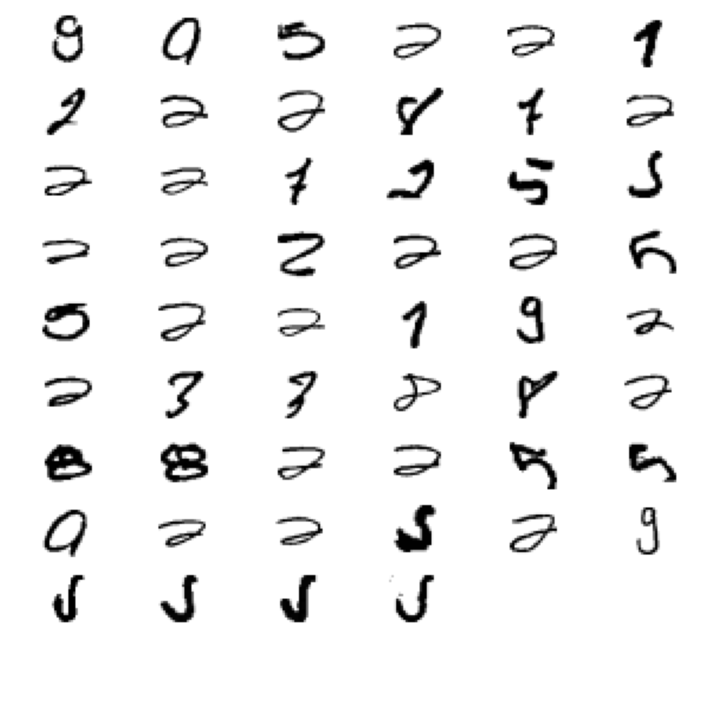

In [63]:
outlier_ids = (cluster_labels == -1) | (cluster_labels == 3) | (cluster_labels == 4) | (cluster_labels == 9) | (cluster_labels == 13)
outliers_images = train_inputs[outlier_ids]

fig, ax_array = plt.subplots(10, 6, figsize=(10, 10))
axes = ax_array.flatten()

for i in range(outliers_images.shape[0]):
    ax = axes[i]
    ax.imshow(outliers_images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

print(f'Total Outliers = {outliers_images.shape[0]}')

# KNN Classification + Removing Outliers + UMAP

In [88]:
x_train = x_train[~outlier_ids]
y_train = y_train[~outlier_ids]

dim_reducer2 = umap.UMAP(random_state=random_state)
x_train_reduced = dim_reducer2.fit_transform(x_train, y_train)
x_test_reduced = dim_reducer2.transform(x_test)

knn_clf = KNeighborsClassifierEx(n_neighbors, weights='distance', n_jobs=-1)
knn_clf.fit(x_train_reduced, y_train)
y_pred = knn_clf.predict(x_test_reduced)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

f'Accuracy = {accuracy}'

'Accuracy = 0.9591'

# Plotting Dataset without Outliers

Text(0.5, 1.0, 'UMAP projection of the Digits dataset')

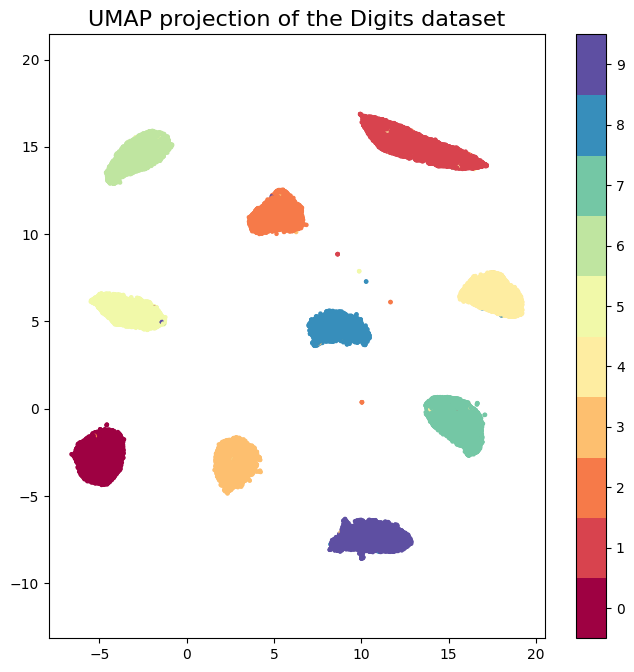

In [89]:
plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(x_train_reduced[:, 0], x_train_reduced[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=16)